Credits: Raschka et al., Chap 14

## Convolutional Neural Network - Part 1

In [1]:
from IPython.display import Image
from IPython.display import display
%matplotlib inline

**Outline**

- [The building blocks of CNNs](#The-building-blocks-of-CNNs)
  - [Understanding CNNs and feature hierarchies](#Understanding-CNNs-and-feature-hierarchies)
  - [Performing discrete convolutions](#Performing-discrete-convolutions)
    - [Discrete convolutions in one dimension](#Discrete-convolutions-in-one-dimension)
    - [Padding inputs to control the size of the output feature maps](#Padding-inputs-to-control-the-size-of-the-output-feature-maps)
    - [Determining the size of the convolution output](#Determining-the-size-of-the-convolution-output)
    - [Performing a discrete convolution in 2D](#Performing-a-discrete-convolution-in-2D)
  - [Subsampling layers](#Subsampling-layers)
- [Putting everything together -- implementing a CNN](#Putting-everything-together----implementing-a-CNN)
  - [Working with multiple input or color channels](#Working-with-multiple-input-or-color-channels)
  - [Regularizing an NN with L2 regularization and dropout](#Regularizing-an-NN-with-L2-regularization-and-dropout)
  - [Loss functions for classification](#Loss-functions-for-classification)
- [Implementing a deep CNN using PyTorch](#Implementing-a-deep-CNN-using-PyTorch)
  - [The multilayer CNN architecture](#The-multilayer-CNN-architecture)
  - [Loading and preprocessing the data](#Loading-and-preprocessing-the-data)
  - [Implementing a CNN using the torch.nn module](#Implementing-a-CNN-using-the-torch.nn-module)
    - [Configuring CNN layers in PyTorch](#Configuring-CNN-layers-in-PyTorch)
    - [Constructing a CNN in PyTorch](#Constructing-a-CNN-in-PyTorch)

###  The building blocks of convolutional neural networks


CNN inspired by the functioning of the visual cortex in our brain.
Experiment in 1959 with an anesthetized cat.
Neurons respond differently after projecting different patterns of light in front of the cat.
Primary layers of the viual cortex detects edges and straight lines, highger order layers focus more on extracting complex shapes.  

In CNN, early layers extract low-level features from the raw data, later layers (often fully connected as in MLP) use these features to predict a target value.

CNN typically perform well on image data.

In Fig. 1, you see how to create **feature maps** from an image.
The local patch of pixels is referred to as **local receptive field**.

In [2]:
# FIG 1
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig1_lec10.png", height=200))

CNN performs well on image-related tasks largely due to two ideas:

* **Sparse connectivity**: A single element in the feature map (output of the convolutional layer) is connected to only a small patch of pixels. This is very different from MLP (connections to the whole image).

* **Parameter sharing**: The same weights are used for different patches of the input image using the same filter.

CNN made of following layers:

* convolutional -> have learnable parameters

* subsampling -> no learnable parameters

* fully connected -> have learnable parameters


### Performing discrete convolutions

Convolution applies a small filter (kernel) over the input x, allowing it to detect local structures like edges, textures, and patterns.


**Discrete convolutions in one dimension**





https://en.wikipedia.org/wiki/Convolution

We want to achieve this through a **filter** (**w**) :

$$ y[i] = \sum_{k=-\infty}^{+\infty} x[i - k] w[k] $$


Before applying the above, first thing we might need to do is **padding**.


In [3]:


# FIG 2
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig2_lec10.png", width=600))

Then, after padding, you can calculate the convolution this way:

In [4]:
# FIG 3
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig3_lec10.png", width=600))

Okay, one thing at the time. Let's take a look at padding first.

### Padding inputs to control the size of the output feature maps

**`Why Padding Matters?`**
- Prevents excessive shrinking of feature maps in deep networks.
- Controls how much context the kernel sees near the edges.
- Balances computational efficiency vs. accuracy.


**1. `Full Padding`**
- **Adds the most padding** (zero-padding around the input).
- The output is **larger** than the input.
- Ensures that the kernel has a valid position even at the edges.


**2. `Same Padding`** (Most common in CNNs)
- **Adds just enough padding** so that the output size remains **the same** as the input size (assuming stride = 1).
- This helps preserve spatial dimensions throughout the layers.


**3. `Valid Padding`** (No Padding)
- **No padding is added**, meaning the kernel only moves over the valid input positions.
- The output is **smaller** than the input.





In [5]:
# FIG 4
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig4_lec10.png", width=600))

### Determining the size of the convolution output

An important formula to remember is

$$ o = \left\lfloor \frac{n + 2p - m}{s} \right\rfloor + 1 $$

which gives the convolution output

In [6]:
import torch
import numpy as np

print('PyTorch version:', torch.__version__)
print('NumPy version: ', np.__version__)

PyTorch version: 2.5.1+cu124
NumPy version:  1.26.4




---


Some gym... 😴 ⏰

In [ ]:
w = [1, 0, 3, 1, 2]

In [ ]:
w[: :-1]

[2, 1, 3, 0, 1]

In [ ]:
w = np.zeros((4,5))

In [ ]:
np.shape(w)

(4, 5)

In [ ]:
w[2,3]=-17
w[1,2]=3.
w[3,1] =2.

In [ ]:
w

array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   3.,   0.,   0.],
       [  0.,   0.,   0., -17.,   0.],
       [  0.,   2.,   0.,   0.,   0.]])

In [ ]:
w[: : -2]

array([[0., 2., 0., 0., 0.],
       [0., 0., 3., 0., 0.]])

In [ ]:
w[: :]

array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   3.,   0.,   0.],
       [  0.,   0.,   0., -17.,   0.],
       [  0.,   2.,   0.,   0.,   0.]])

In [ ]:
w = [1, 0, 3, 1, 2]

In [ ]:
w[: : -1]

[2, 1, 3, 0, 1]



---



In [7]:
## 1D convolutional

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, (int((len(x_padded) - len(w_rot))/s) + 1), s):
        res.append(np.sum(
            x_padded[i:i + w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print(np.array(w[::-1]))
print(np.shape(np.array(w[::-1])))
print(np.array(w[::-1]).shape[0])

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same'))

[2 1 3 0 1]
(5,)
5
Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


In [8]:
w = np.zeros((3,3))
w[1,2]=-1.
w[0,1]=3.
w[2,1]=2.
print(w)

[[ 0.  3.  0.]
 [ 0.  0. -1.]
 [ 0.  2.  0.]]


In [9]:
w[::-1]

array([[ 0.,  2.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  3.,  0.]])

In [10]:
w[::-1, ::-1] # "180 degree operation"

array([[ 0.,  2.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  3.,  0.]])

### Performing a discrete convolution in 2D




In [11]:
# FIG 5
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig5_lec10.png", width=600))

Suppose you want to do this convolution


In [12]:
# conv 2d
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/conv2d_lec10.png", width=600))

Consider the following image: what values of p, m and s have been used in the convolution?

In [13]:
# FIG 6
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig6_lec10.png", width=600))

In [14]:
p=(0, 0)
X_orig = np.zeros((3,3))
n1 = X_orig.shape[0] + 2*p[0]
n2 = X_orig.shape[1] + 2*p[1]

print(n1, n2)

3 3


In [15]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    print(W_rot)

    res = []
    for i in range(0, (int((X_padded.shape[0] -
                            W_rot.shape[0]) / s[0]) + 1), s[0]):
        res.append([])
        for j in range(0, (int((X_padded.shape[1] -
                                W_rot.shape[1]) / s[1]) + 1), s[1]):
            X_sub = X_padded[i:i + W_rot.shape[0],
                    j:j + W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))


[[1 1 0]
 [1 2 1]
 [3 0 1]]
Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### Subsampling layers

In [17]:
# FIG 7
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig7_lec10.png", height=250))

### Putting everything together – implementing a CNN

**Working with multiple input or color channels**



In the following example:

* The input has 3 channels

* Each filter has a depth of 3, matching the number of input channels.

* The number of filters (C_out = 5) determines the number of output feature maps. Each filter produces one feature map, meaning the output has 5 feature maps.

* A pooling operation (e.g., max pooling, average pooling) is applied.
It reduces spatial dimensions while maintaining 5 feature maps


In [18]:
# FIG 8
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig8_lec10.png", width=600))

### The multilayer CNN architecture with PyTorch

In [19]:
# FIG 10
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig10_lec10.png", width=600))

N.b.:

* **Convolution**: default values of stride=1, padding=0 [https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html]

* **Pooling**: default value of stride = kernel size [https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html]


#### Loading and preprocessing the data

In [20]:
import numpy as np
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
  print('cpu')

cuda
Tesla T4


In [80]:
image_path = './'  # see root=image_path, which specifies the directory where the dataset will be stored or loaded from.

# transforms.Compose is a function that composes several transforms together

# transforms.ToTensor() converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
# In other words, if you apply transforms.ToTensor(), it automatically scales the values to the range [0, 1].
# This is necessary as PyTorch models expect inputs to be tensors.

transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True, # the training set of the MNIST dataset is being requested.
                                           transform=transform, # transform=transform applies the transformation defined earlier
                                           download=True) # tells the library to download the dataset if it's not available at the specified root


from torch.utils.data import Subset

# create a validation subset
# torch.arange(10000) generates indices from 0 to 9999, selecting the first 10,000 samples from mnist_dataset to be used as validation
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))

# selects the remaining samples
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

# the test set size is inherently predefined to be 10,000 images, no further specification is needed
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=False)

#---- please notice that mnist_test_dataset still require to be scaled, differently from mnist_train_dataset and mnist_valid_dataset
#---- see later


In [23]:
print(len(mnist_train_dataset),len(mnist_valid_dataset),len(mnist_test_dataset))

sample_image, sample_label = mnist_train_dataset[0]

print(sample_image.shape, sample_label)

# consistent NCHW format



50000 10000 10000
torch.Size([1, 28, 28]) 3


In [39]:
# We construct the data loader with batches of batch_size images for the training set and validation set

from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False) #Why?


In [46]:
for tmpbatch in train_dl:
  #print(type(tmpbatch))
  break

In [45]:
tmp_in = tmpbatch[0]
tmp_out = tmpbatch[1]

print(tmp_in.shape, tmp_out.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [64]:
print(tmp_in.min())

tensor(0.)



#### Configuring CNN layers in PyTorch

 * **Conv2d:** `torch.nn.Conv2d`
   * `out_channels`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **MaxPool2d:** `torch.nn.MaxPool2d`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **Dropout** `torch.nn.Dropout`
   * `p`

### Constructing a CNN in PyTorch

In [25]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)) # A convolution operation is linear...
model.add_module('relu1', nn.ReLU())                  # The activation function makes the model non-linear, allowing it to learn more complex patterns...
model.add_module('pool1', nn.MaxPool2d(kernel_size=2)) #if stride=None, default is kernel_size
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [26]:
# PyTorch provides a convenient method to compute the size of the feature map for us

x = torch.ones((4, 1, 28, 28))
print(model(x).shape)
print(type(model(x).shape))

print(torch.prod(torch.tensor(model(x).shape)[1:]))


torch.Size([4, 64, 7, 7])
<class 'torch.Size'>
tensor(3136)


In [27]:
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

Let's add dropout

In [28]:
# FIG 9
display(Image(url="https://raw.githubusercontent.com/cfteach/NNDL_DATA621/webpage-src/DATA621/DATA621/images/Fig9_lec10.png", width=600))

In [29]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

# --- Why dropout here?
# Earlier (e.g., right before relu3) application of dropout might lead to underfitting since ReLU turns all negative values to zero
# Dropout early in deep networks can severely limit the amount of learnable information,
# while dropout late in the network should be tuned to avoid overly damping the outputs (over-regularization).
# After ReLU and between (middle) layers.

model.add_module('fc2', nn.Linear(1024, 10))

In [30]:
device = torch.device("cuda:0")
#device = torch.device("cpu")

model = model.to(device)

In [60]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):

    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):

        #------ model.train() sets the model to training mode ------#
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            #
            loss.backward()       # computes gradients
            optimizer.step()      # updates model parameters with gradients
            optimizer.zero_grad() # resets all gradients to zero before the next backpropagation step
            #
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)  #loss.item() gives the average loss in the batch
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        #------  model.eval() sets the model to evaluation mode ------#
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 5
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9877 val_accuracy: 0.9836
Epoch 2 accuracy: 0.9873 val_accuracy: 0.9881
Epoch 3 accuracy: 0.9921 val_accuracy: 0.9878
Epoch 4 accuracy: 0.9947 val_accuracy: 0.9910
Epoch 5 accuracy: 0.9947 val_accuracy: 0.9902


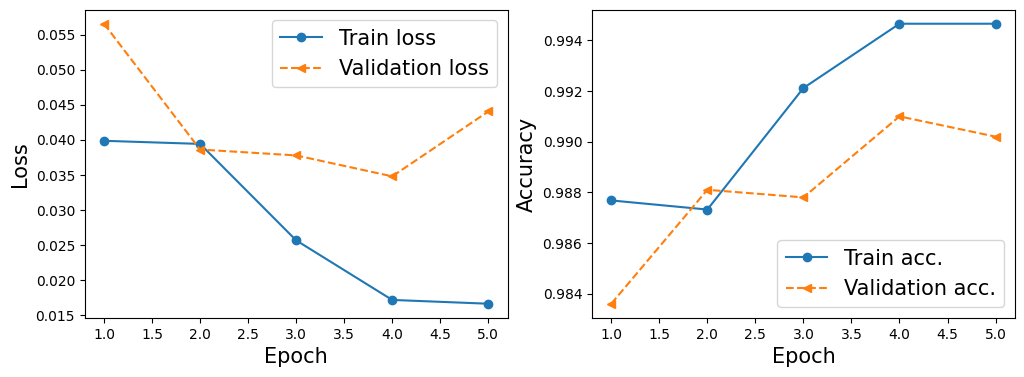

In [61]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1  # number of epochs

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [81]:
# cuda.synchronize()
# It is used to synchronize all CUDA operations.
# When you are running PyTorch on a GPU, operations are often asynchronous for efficiency.
# It ensures that all preceding CUDA operations are finished before moving on, important before switching from GPU to CPU.

torch.cuda.synchronize()

# moves the model from the GPU to the CPU.
model_cpu = model.cpu()


#pred = model(mnist_test_dataset.data.unsqueeze(1).float()) #.unsqueeze(1)/ 255.
pred = model(mnist_test_dataset.data.unsqueeze(1)/255.)

is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')


Test accuracy: 0.9899


In [82]:
print(mnist_test_dataset.data.shape)
print(mnist_test_dataset.data.unsqueeze(1).shape)
#mnist_test_dataset.data[0]

torch.Size([10000, 28, 28])
torch.Size([10000, 1, 28, 28])


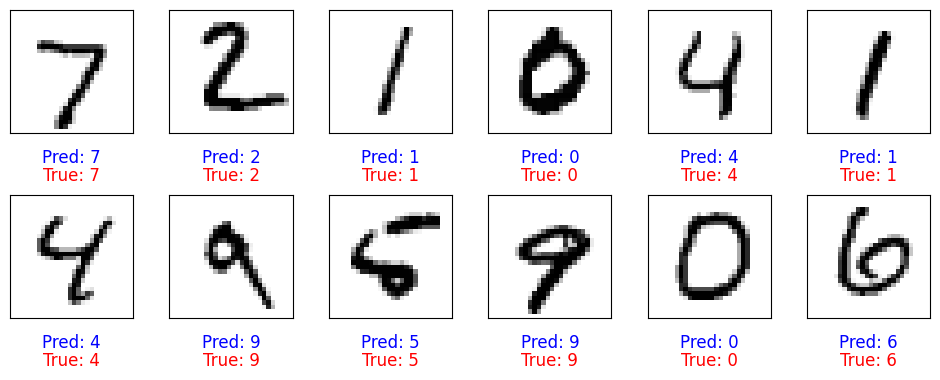

In [83]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img, true_label = mnist_test_dataset[i]
    img = img[0, :, :]  # Get the 2D image data from the tensor
    #img = mnist_test_dataset[i][0][0, :, :]   # mnist_test_dataset[i] contain image (tensor) and target (int)
    pred = model(img.unsqueeze(0).unsqueeze(1)) # unsqueeze adds a new dimension to a tensor at a specified position

    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')

    # Add both predicted and ground truth labels to the plot
    ax.text(0.5, -0.2, f'Pred: {y_pred.item()}', size=12, color='blue',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, -0.35, f'True: {true_label}', size=12, color='red',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Adjust vertical spacing between rows (increase hspace)
plt.subplots_adjust(hspace=0.5)  # Increase space between rows (default is 0.2)


plt.show()

### Randomly select an image, rotate, and make prediction

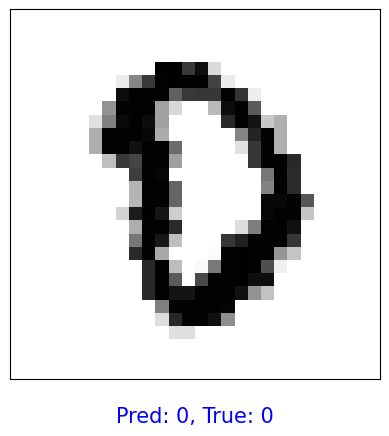

angle: 19.74


In [97]:
import random
import torchvision.transforms.functional as TF

# Randomly select an image from the MNIST test dataset
random_idx = random.randint(0, len(mnist_test_dataset) - 1)  # Select a random index
img, true_label = mnist_test_dataset[random_idx]  # Get the image and true label
img = img.unsqueeze(0)  # Add batch dimension [1, 1, 28, 28]

# Rotate the image by a random angle
angle = random.uniform(-55, 55)  # Choose a random angle between -90 and 90 degrees
rotated_img = TF.rotate(img, angle)  # Rotate the image

# Make a prediction with the rotated image
pred = model(rotated_img)  # Run through the model
y_pred = torch.argmax(pred)  # Get the predicted label

# Plot the rotated image and show both the prediction and the true label
fig, ax = plt.subplots()
ax.set_xticks([]); ax.set_yticks([])

# Display the rotated image
ax.imshow(rotated_img.squeeze(), cmap='gray_r')

# Show predicted and true labels
ax.text(0.5, -0.1, f'Pred: {y_pred.item()}, True: {true_label}', size=15, color='blue',
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.show()

print(f"angle: {angle:1.2f}")

### Add an extra convolutional layer

Can you add to the prior model, before flattening, an extra convolutional layer 5x5x128? Please adjust the two FC layers to match the new dimensions.